In [1]:
###############################################################################
# Boston Dataset: lineare Regression
# Sidney Göhler 544131
#### IKT (M)
# Special Engineering SoSe20
# Prof. Dr. Andreas Zeiser
###############################################################################
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.gridspec as gridspec
# import seaborn as sns #pip install searborn
import logistische_regression as lr
import time

from sklearn.datasets import load_digits
from scipy.stats.kde import gaussian_kde

In [2]:
####################
# load datasets
####################
dataset = load_digits()
#print(dataset.DESCR, '\n', '\n')
X = dataset.data
y = dataset.target

targets = dataset.target_names
images = dataset.images



In [3]:
mean, std = lr.StandardScaler_fit(X)

X = lr.StandardScaler_transform(X, mean, std+10)

In [4]:
print(np.max(X),np.min(X))

1.3473056603822613 -0.8571148139579597


digit = 0 at index = 0


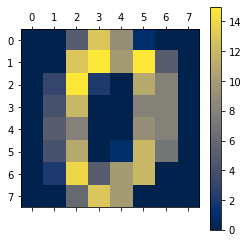

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]



digit = 0 at index = 20


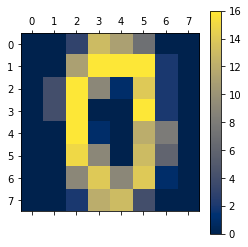

[[ 0.  0.  3. 13. 11.  7.  0.  0.]
 [ 0.  0. 11. 16. 16. 16.  2.  0.]
 [ 0.  4. 16.  9.  1. 14.  2.  0.]
 [ 0.  4. 16.  0.  0. 16.  2.  0.]
 [ 0.  0. 16.  1.  0. 12.  8.  0.]
 [ 0.  0. 15.  9.  0. 13.  6.  0.]
 [ 0.  0.  9. 14.  9. 14.  1.  0.]
 [ 0.  0.  2. 12. 13.  4.  0.  0.]]



digit = 8 at index = 500


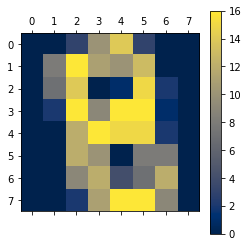

[[ 0.  0.  3. 10. 14.  3.  0.  0.]
 [ 0.  8. 16. 11. 10. 13.  0.  0.]
 [ 0.  7. 14.  0.  1. 15.  2.  0.]
 [ 0.  2. 16.  9. 16. 16.  1.  0.]
 [ 0.  0. 12. 16. 15. 15.  2.  0.]
 [ 0.  0. 12. 10.  0.  8.  8.  0.]
 [ 0.  0.  9. 12.  4.  7. 12.  0.]
 [ 0.  0.  2. 11. 16. 16.  9.  0.]]



digit = 8 at index = 508


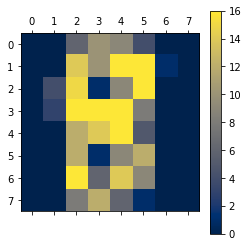

[[ 0.  0.  6. 10.  9.  4.  0.  0.]
 [ 0.  0. 14. 10. 16. 16.  1.  0.]
 [ 0.  4. 15.  1.  9. 16.  0.  0.]
 [ 0.  3. 16. 16. 16.  8.  0.  0.]
 [ 0.  0. 12. 14. 16.  5.  0.  0.]
 [ 0.  0. 12.  1.  9. 12.  0.  0.]
 [ 0.  0. 16.  6. 14.  9.  0.  0.]
 [ 0.  0.  8. 12.  6.  1.  0.  0.]]



digit = 5 at index = 1700


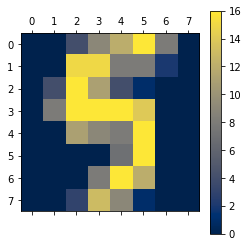

[[ 0.  0.  4.  9. 12. 16.  8.  0.]
 [ 0.  0. 15. 15.  8.  8.  2.  0.]
 [ 0.  4. 16. 11.  4.  1.  0.  0.]
 [ 0.  8. 16. 16. 16. 14.  0.  0.]
 [ 0.  0. 11.  9.  8. 16.  0.  0.]
 [ 0.  0.  0.  0.  7. 16.  0.  0.]
 [ 0.  0.  0.  8. 16. 12.  0.  0.]
 [ 0.  0.  3. 13.  9.  1.  0.  0.]]



digit = 5 at index = 1787


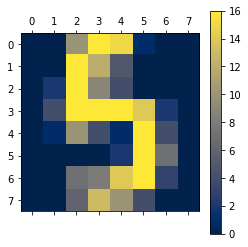

[[ 0.  0. 10. 16. 15.  1.  0.  0.]
 [ 0.  0. 16. 12.  5.  0.  0.  0.]
 [ 0.  2. 16.  9.  4.  0.  0.  0.]
 [ 0.  4. 16. 16. 16. 14.  2.  0.]
 [ 0.  1. 10.  4.  1. 16.  4.  0.]
 [ 0.  0.  0.  0.  2. 16.  7.  0.]
 [ 0.  0.  7.  8. 14. 16.  3.  0.]
 [ 0.  0.  6. 13. 10.  4.  0.  0.]]





In [15]:
for ind in [0,20,500,508,1700,1787]:
    print(f'digit = {y[ind]} at index = {ind}')
    plt.matshow(images[ind], cmap = cm.cividis)
    plt.colorbar()
    plt.show()
    print(f'{images[ind]}\n\n\n')

In [5]:
####################
# split dataset (80:20)
####################


X_train, X_test, y_train, y_test = lr.train_test_split(X, y, 0.8, 0)

In [ ]:
####################
# explore trainingset
####################

# Häufigkeitsverteilung y (target)
fig = plt.figure(figsize=(9, 8))

labels, counts = np.unique(y_train, return_counts=True)

plt.bar(labels, counts, align='center', width=0.95)
plt.gca().set_xticks(labels)
plt.xlabel('digit')
plt.xlim(-1,10)
plt.ylabel('count')
plt.title('relative Häufigkeitsverteilung der digits der Trainingsdaten')
plt.grid(color='0.75', linestyle='-.', linewidth=1, axis='y')
plt.show()

In [ ]:
print(labels,counts)

feature 0 (0):


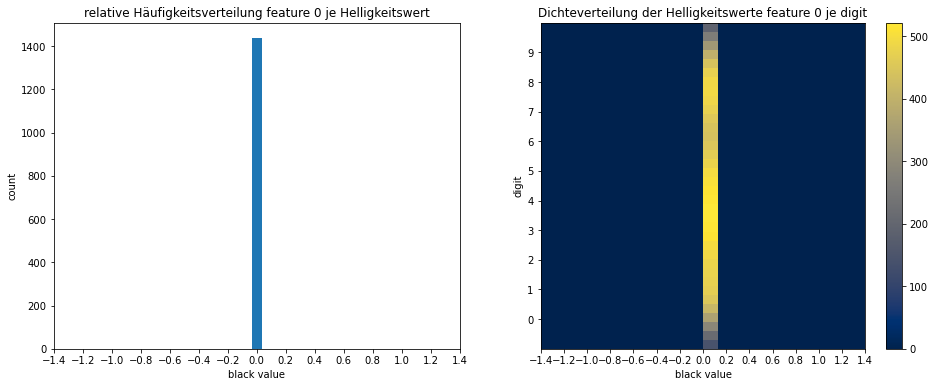

rows = 1437
all numeric = True (float64)
mean = 0.0
std = 0.0
corrcoef = nan 
 

feature 1 (1):


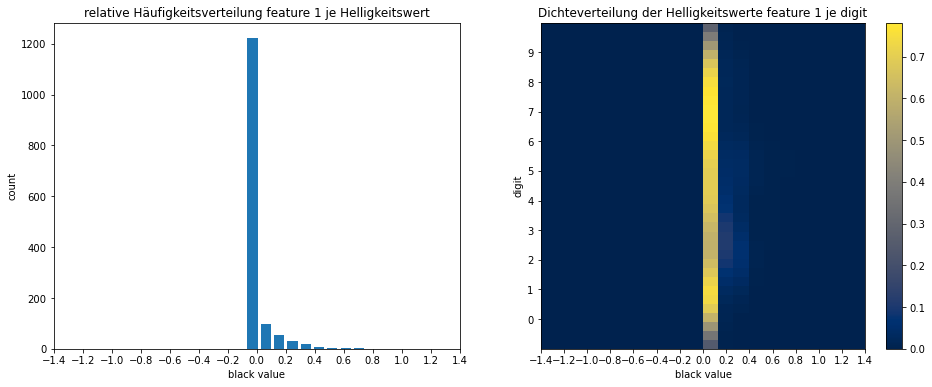

rows = 1437
all numeric = True (float64)
mean = 0.0004710122886216201
std = 0.08325183805461209
corrcoef = 0.47665373748075923 
 

feature 2 (2):


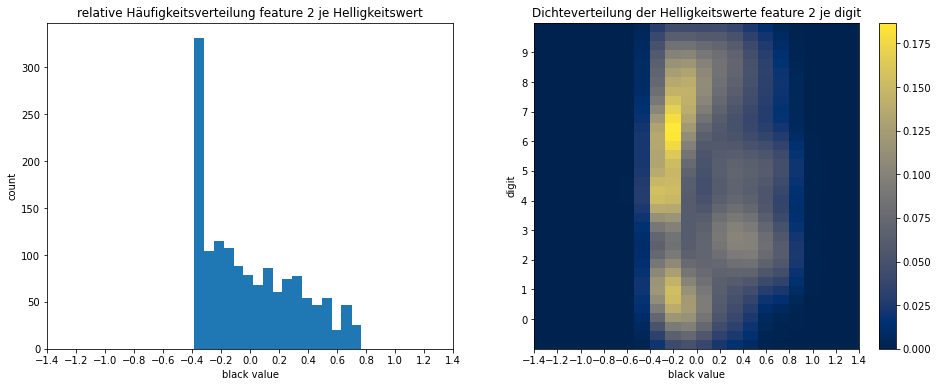

rows = 1437
all numeric = True (float64)
mean = 0.004892407338036322
std = 0.3224111926577562
corrcoef = 0.49390307225187013 
 

feature 3 (3):


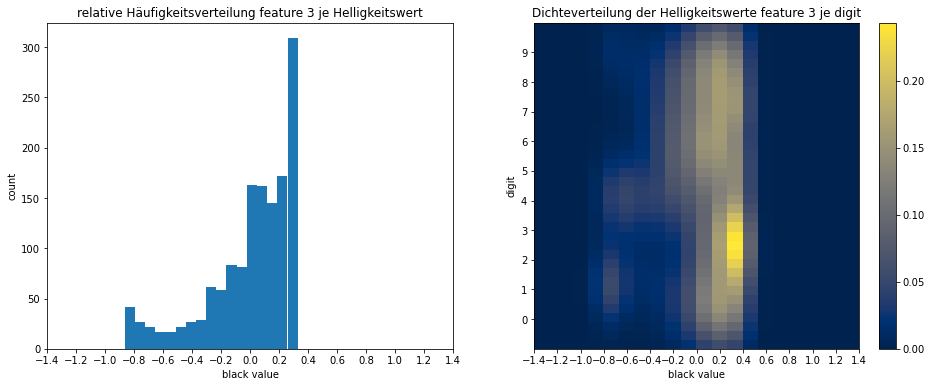

rows = 1437
all numeric = True (float64)
mean = 0.00019055993454752672
std = 0.29775818730535347
corrcoef = 0.4957747685959512 
 

feature 4 (4):


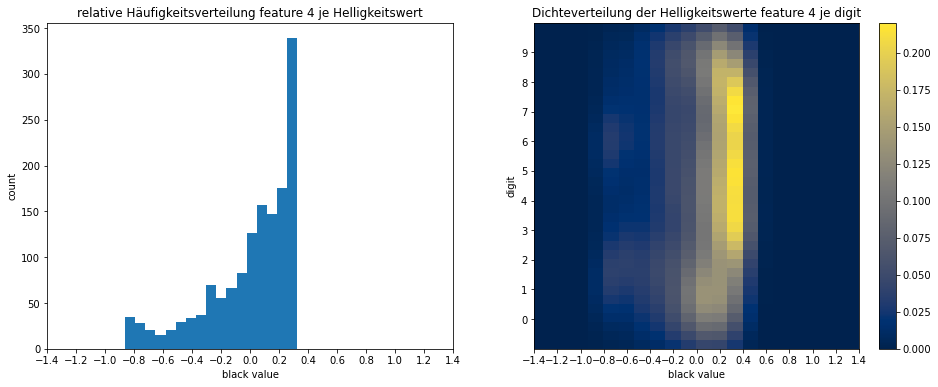

rows = 1437
all numeric = True (float64)
mean = 0.0032786783953340816
std = 0.29915480313861303
corrcoef = 0.5551434466133338 
 

feature 5 (5):


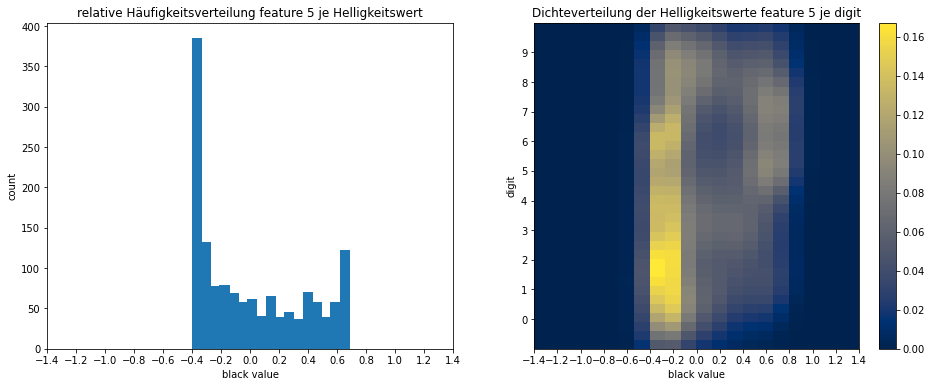

rows = 1437
all numeric = True (float64)
mean = 0.005840378375652761
std = 0.3630717560456795
corrcoef = 0.6003425822288645 
 

feature 6 (6):


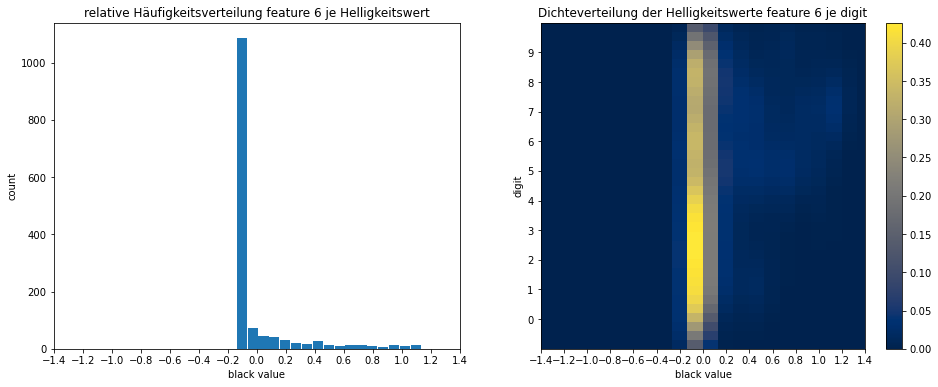

rows = 1437
all numeric = True (float64)
mean = 0.002998638761385466
std = 0.2504476488949631
corrcoef = 0.5992110514947455 
 

feature 7 (7):


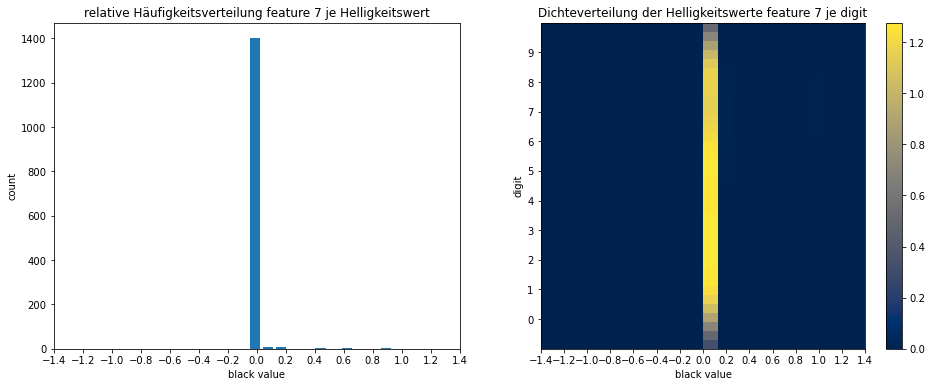

rows = 1437
all numeric = True (float64)
mean = -0.00020946657794893478
std = 0.09607194537983325
corrcoef = 0.549836827442153 
 

feature 8 (8):


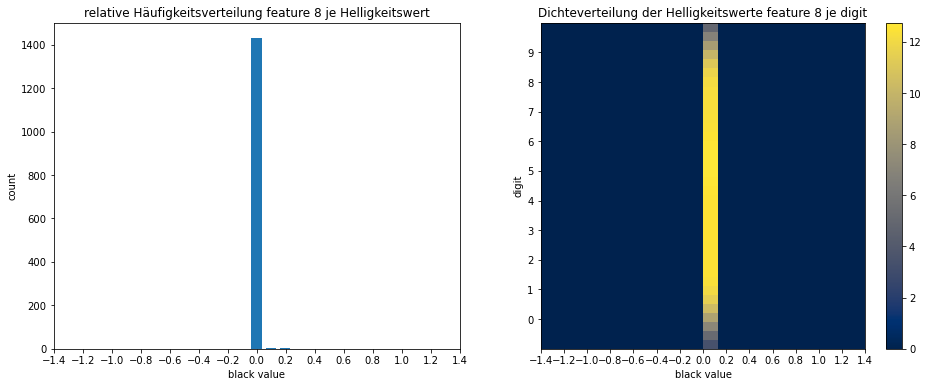

rows = 1437
all numeric = True (float64)
mean = 0.00013811026256791765
std = 0.010430698586700933
corrcoef = 0.5118542936436407 
 

feature 9 (9):


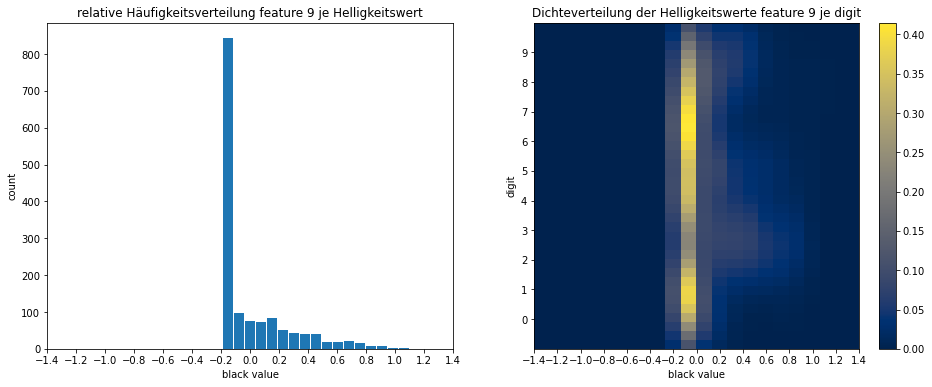

rows = 1437
all numeric = True (float64)
mean = 0.0033645004861258434
std = 0.24764824918310277
corrcoef = 0.49651749852852245 
 

feature 10 (10):


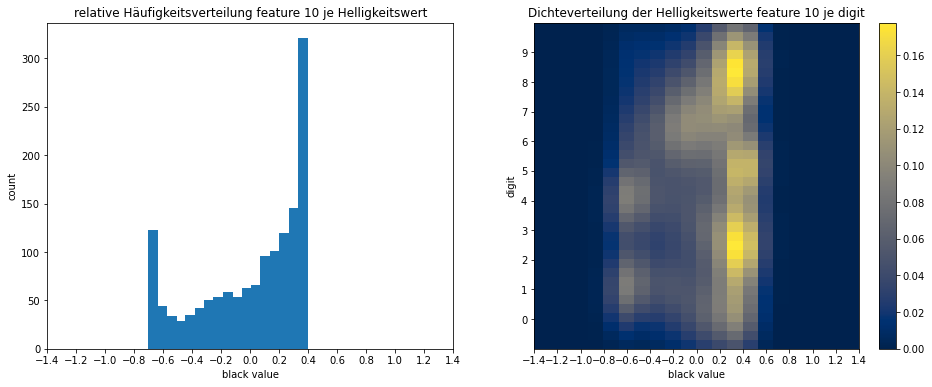

rows = 1437
all numeric = True (float64)
mean = 0.004180316078113595
std = 0.34869767024112497
corrcoef = 0.5583489204073099 
 

feature 11 (11):


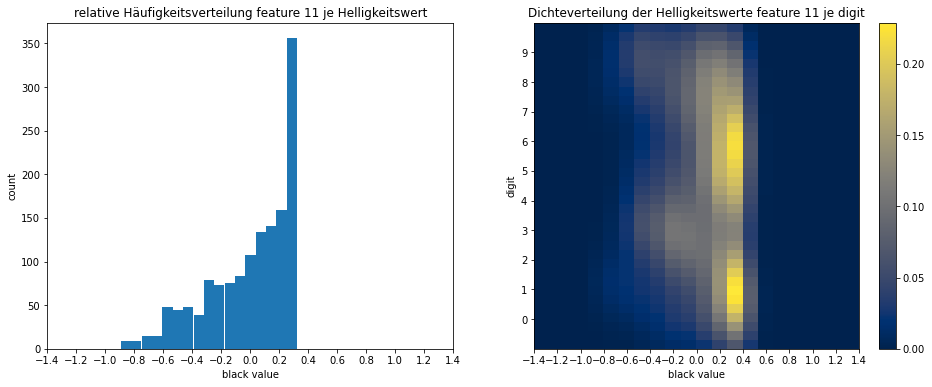

rows = 1437
all numeric = True (float64)
mean = -0.004800422756069524
std = 0.2874811454002691
corrcoef = 0.43664811912319934 
 

feature 12 (12):


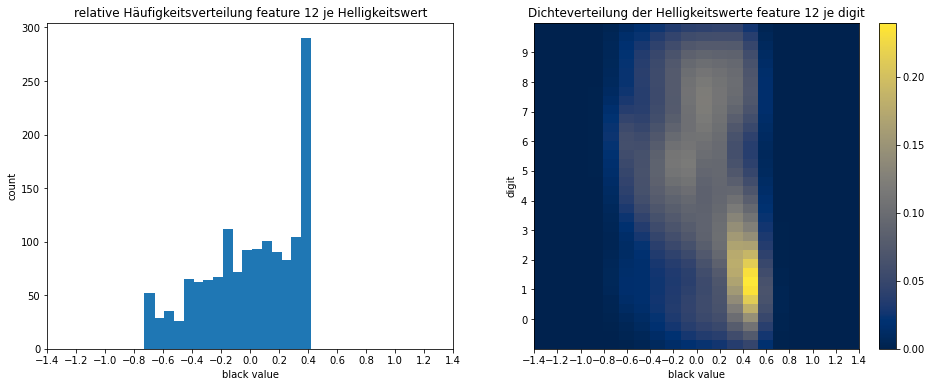

rows = 1437
all numeric = True (float64)
mean = 0.002804395986023791
std = 0.32236420721858966
corrcoef = 0.3736103471827973 
 

feature 13 (13):


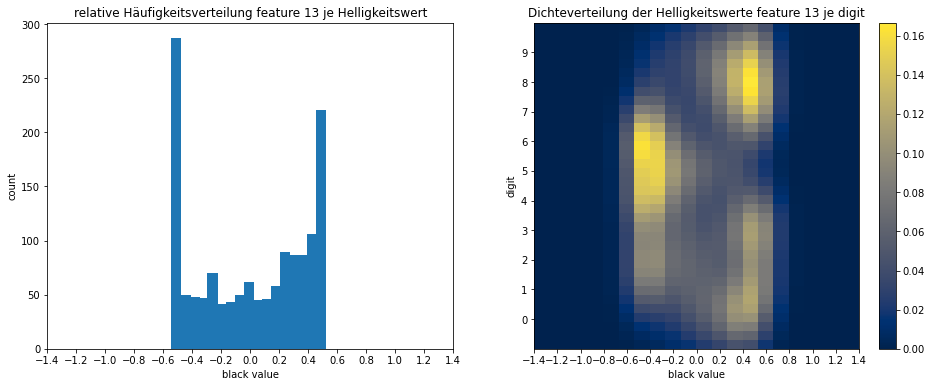

rows = 1437
all numeric = True (float64)
mean = 0.0075135650148065065
std = 0.3752218011138518
corrcoef = 0.5355182069910173 
 

feature 14 (14):


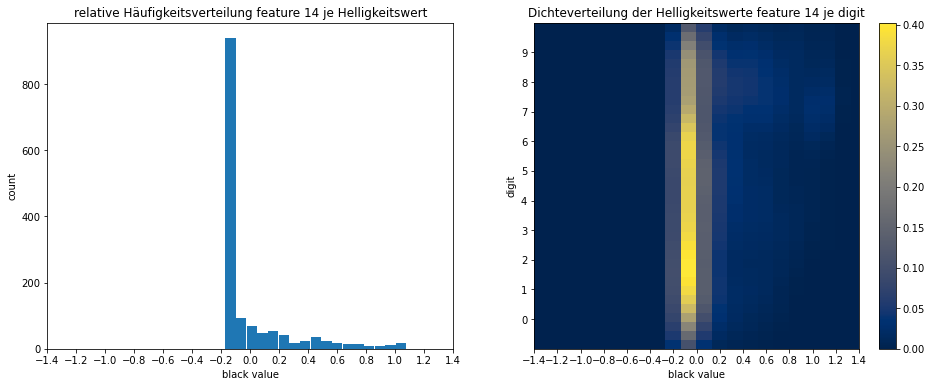

rows = 1437
all numeric = True (float64)
mean = 0.004390296466728569
std = 0.26696797936432154
corrcoef = 0.6061418262444549 
 

feature 15 (15):


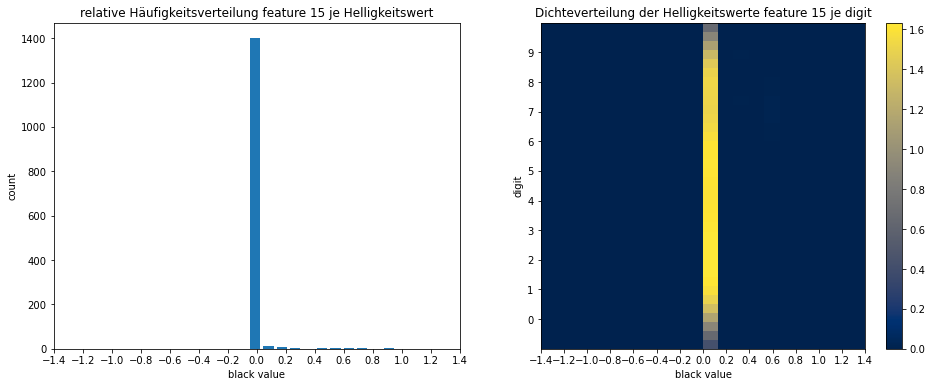

rows = 1437
all numeric = True (float64)
mean = -0.0007156598360196591
std = 0.07315360417255048
corrcoef = 0.5413629222910945 
 

feature 16 (16):


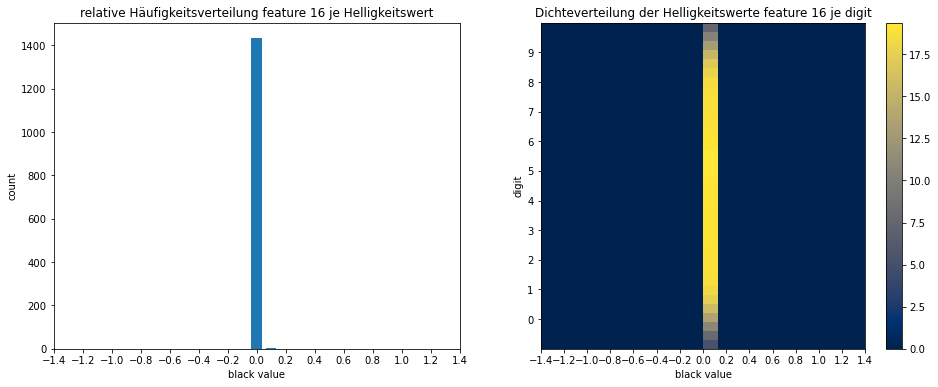

rows = 1437
all numeric = True (float64)
mean = 6.92736705774701e-05
std = 0.006927568366032975
corrcoef = 0.4872139901948622 
 

feature 17 (17):


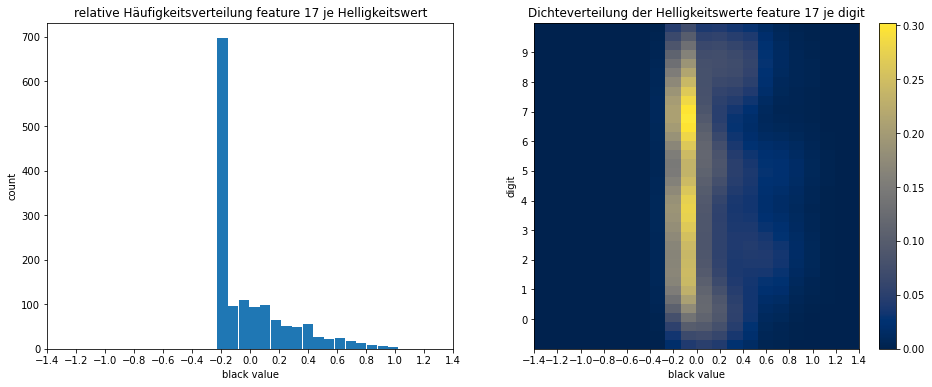

rows = 1437
all numeric = True (float64)
mean = 0.0031557225193269423
std = 0.26480099061769563
corrcoef = 0.48979481117015067 
 

feature 18 (18):


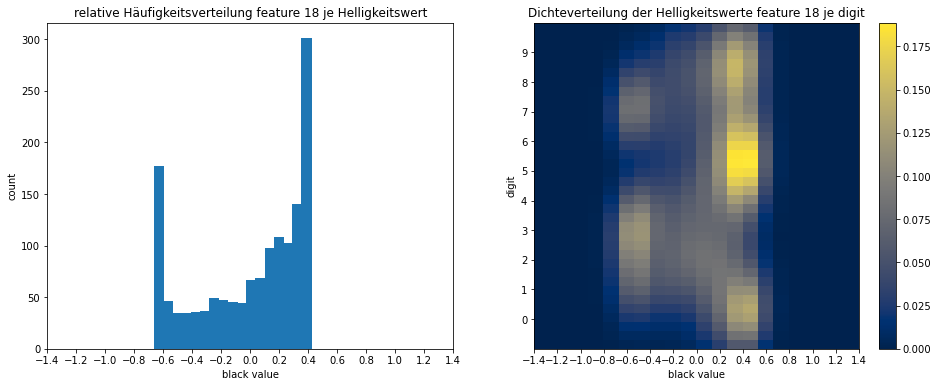

rows = 1437
all numeric = True (float64)
mean = 0.002889371182449236
std = 0.3623650656763001
corrcoef = 0.5467581374375199 
 

feature 19 (19):


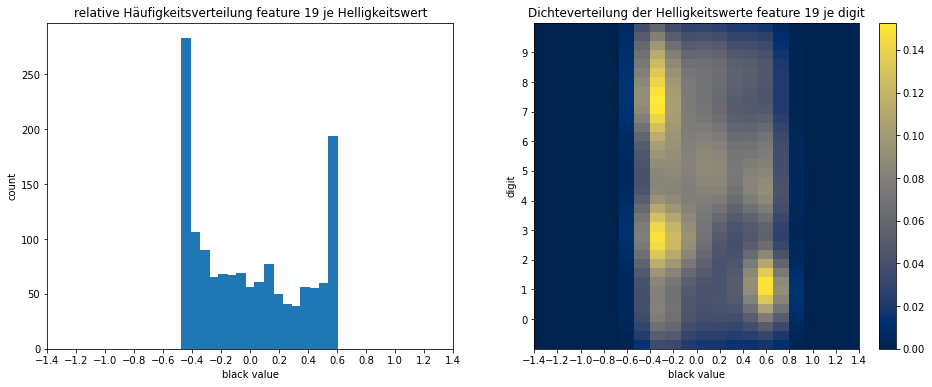

rows = 1437
all numeric = True (float64)
mean = -0.0023167488120802997
std = 0.3681771318153653
corrcoef = 0.427892307471523 
 

feature 20 (20):


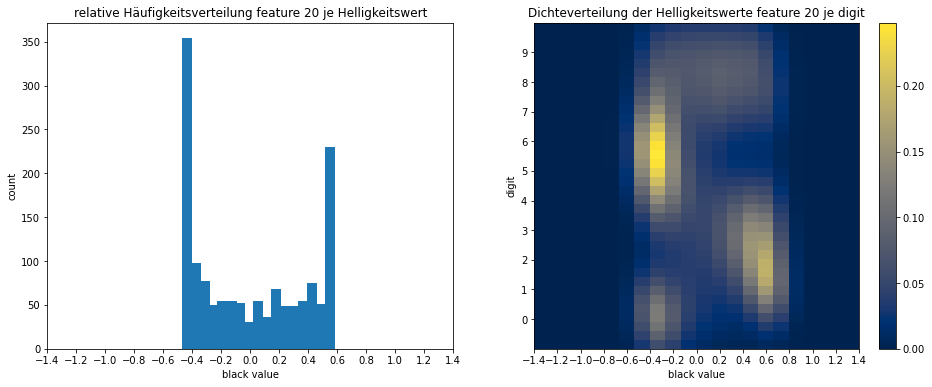

rows = 1437
all numeric = True (float64)
mean = -0.0006342484397936571
std = 0.38137139516638424
corrcoef = 0.4324263812328466 
 

feature 21 (21):


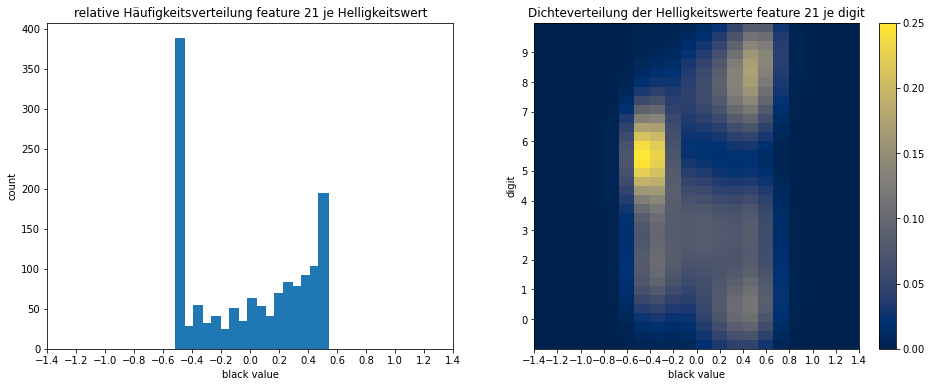

rows = 1437
all numeric = True (float64)
mean = 0.0007856206280871796
std = 0.3824965769698839
corrcoef = 0.5504756203073258 
 

feature 22 (22):


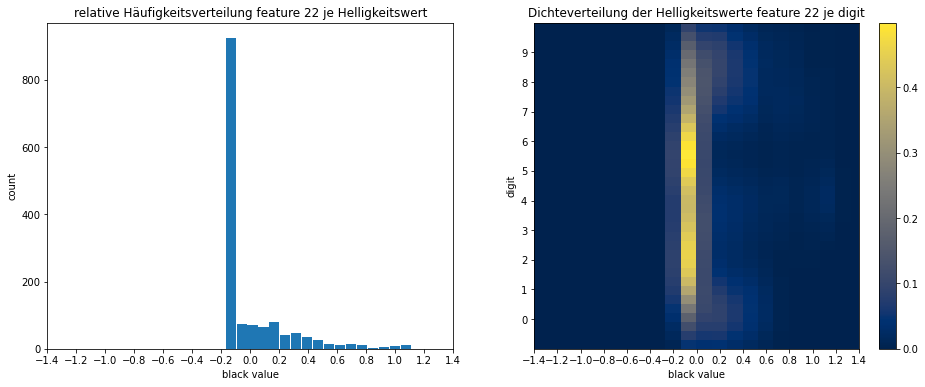

rows = 1437
all numeric = True (float64)
mean = 0.0001507952758384992
std = 0.24461315773032993
corrcoef = 0.5356433446954911 
 

feature 23 (23):


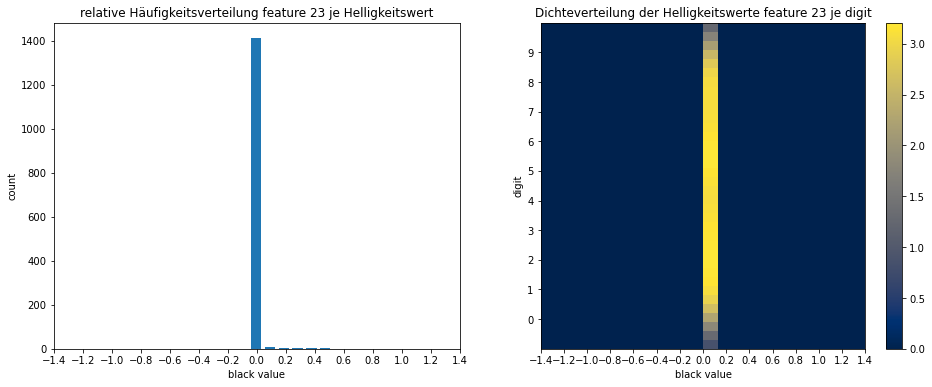

rows = 1437
all numeric = True (float64)
mean = -0.0006646593753849015
std = 0.03793492376215542
corrcoef = 0.5164808789679383 
 

feature 24 (24):


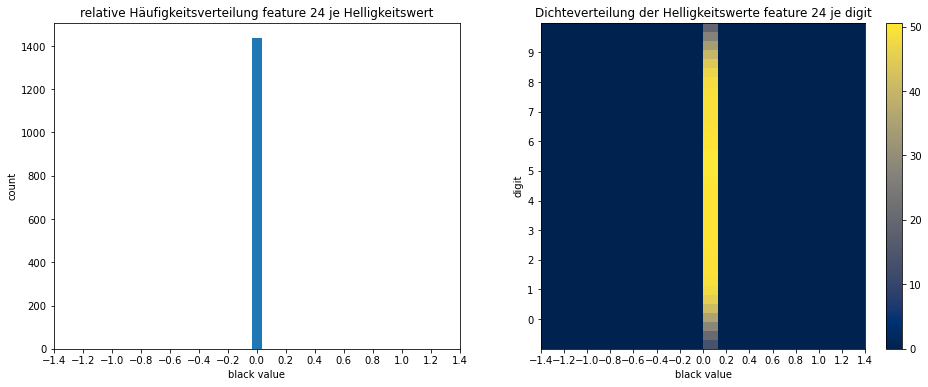

rows = 1437
all numeric = True (float64)
mean = -4.156858268382891e-05
std = 0.002628299248533271
corrcoef = 0.4840461785093534 
 

feature 25 (25):


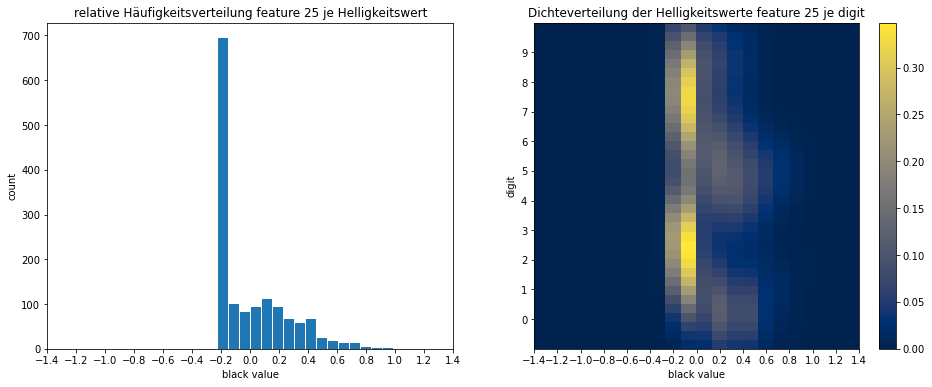

rows = 1437
all numeric = True (float64)
mean = -0.00010154397191284044
std = 0.23901017162105934
corrcoef = 0.41439836315312256 
 

feature 26 (26):


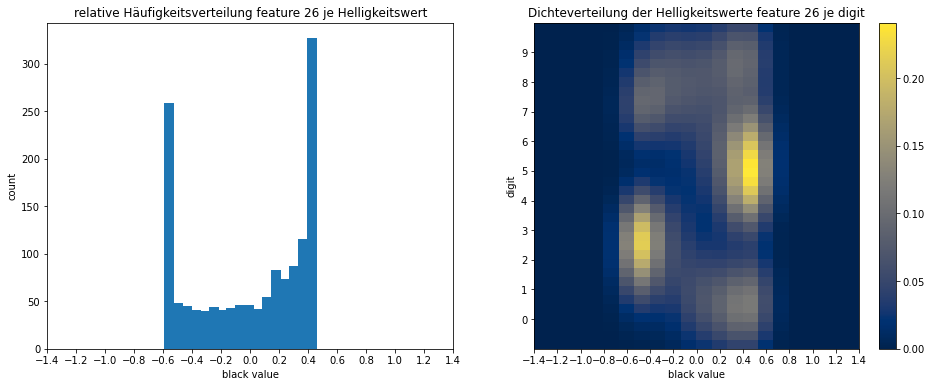

rows = 1437
all numeric = True (float64)
mean = 0.0033893455205429926
std = 0.3805842087331013
corrcoef = 0.5328009977810905 
 

feature 27 (27):


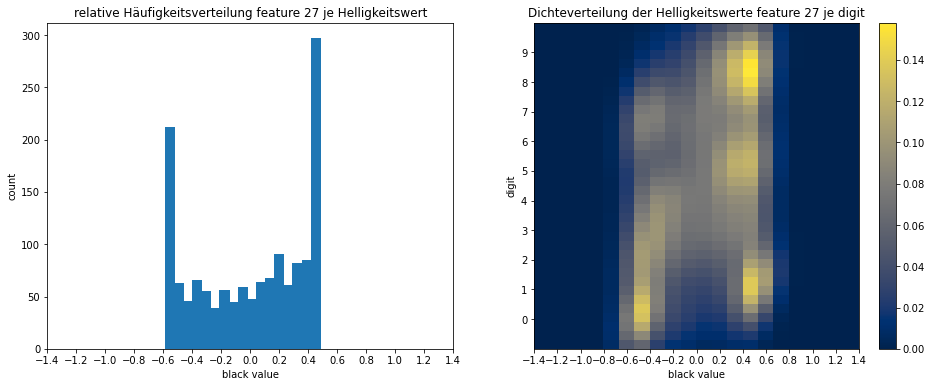

rows = 1437
all numeric = True (float64)
mean = 0.004149294452755036
std = 0.3727286800377198
corrcoef = 0.6371363925866474 
 

feature 28 (28):


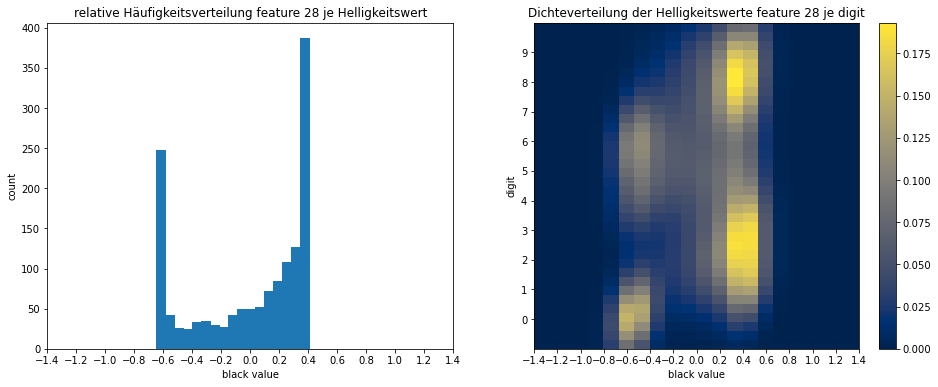

rows = 1437
all numeric = True (float64)
mean = -0.00031212121738727637
std = 0.3796253165136579
corrcoef = 0.6200532882267829 
 

feature 29 (29):


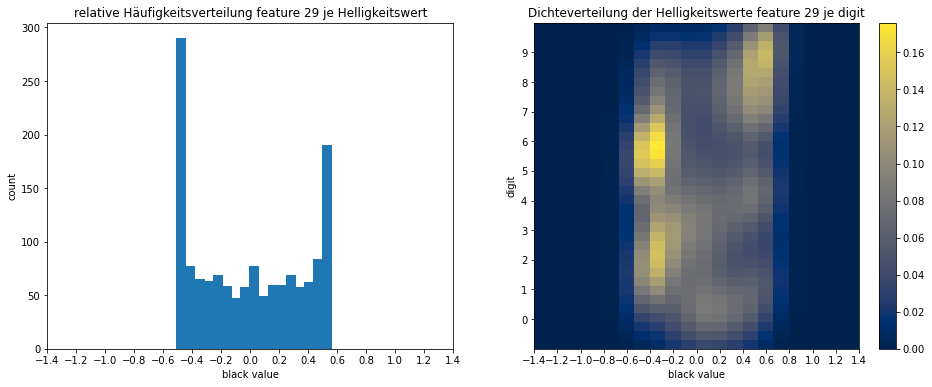

rows = 1437
all numeric = True (float64)
mean = -0.0056768480798851445
std = 0.3701893445918588
corrcoef = 0.6031499671991725 
 

feature 30 (30):


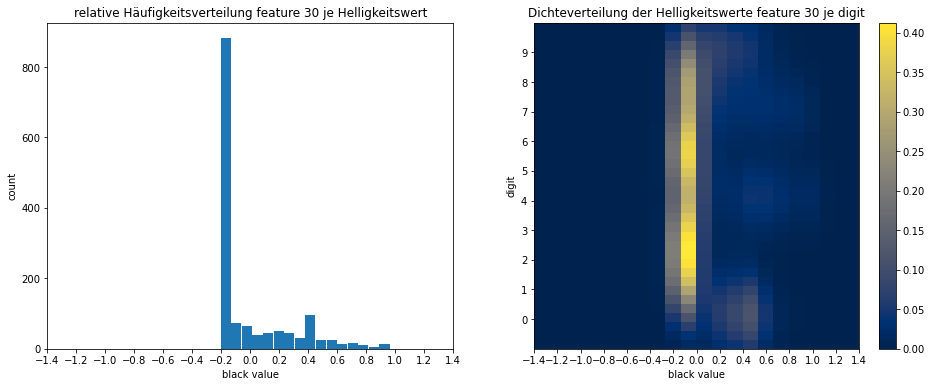

rows = 1437
all numeric = True (float64)
mean = -0.0031327908423939934
std = 0.26748595011496307
corrcoef = 0.49070032878139946 
 

feature 31 (31):


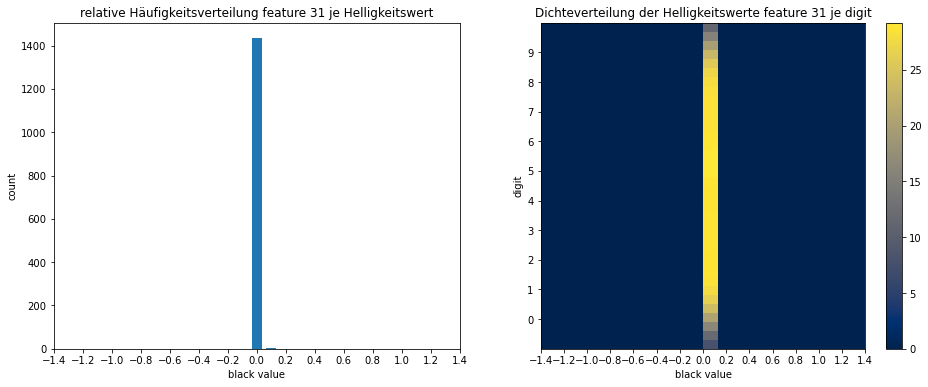

rows = 1437
all numeric = True (float64)
mean = -1.3760096139820182e-05
std = 0.004542935097097087
corrcoef = 0.49625169150028453 
 

feature 32 (32):


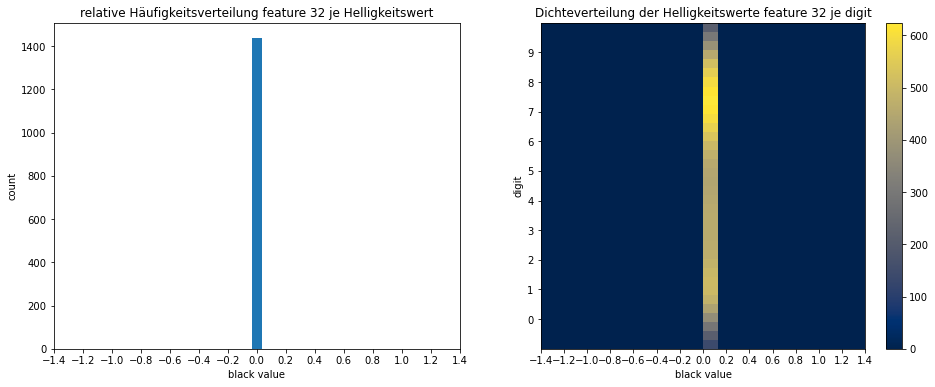

rows = 1437
all numeric = True (float64)
mean = 0.0
std = 0.0
corrcoef = nan 
 

feature 33 (33):


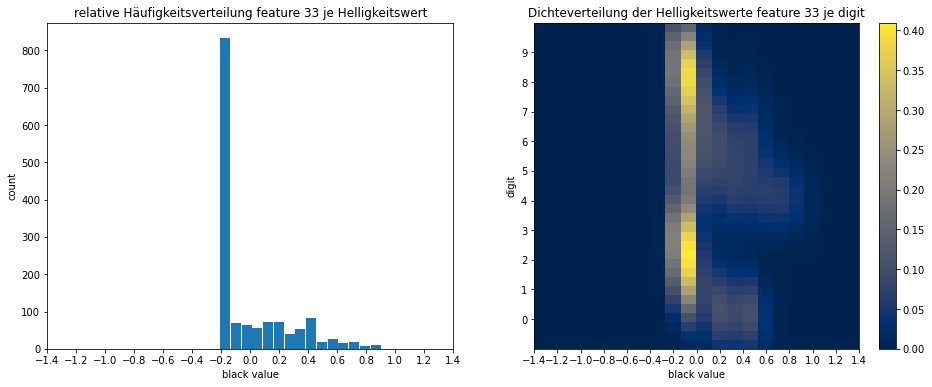

rows = 1437
all numeric = True (float64)
mean = -0.002002917964873776
std = 0.2555328014869149
corrcoef = 0.3847274774782114 
 

feature 34 (34):


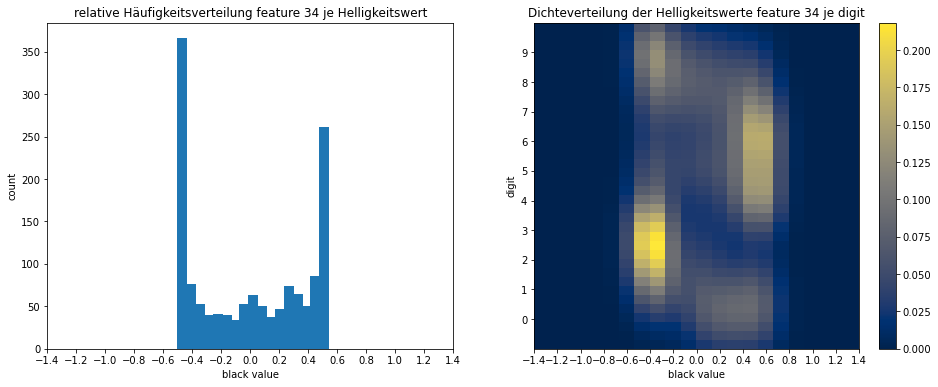

rows = 1437
all numeric = True (float64)
mean = -0.0009720165783841844
std = 0.386757203597699
corrcoef = 0.4939642054927543 
 

feature 35 (35):


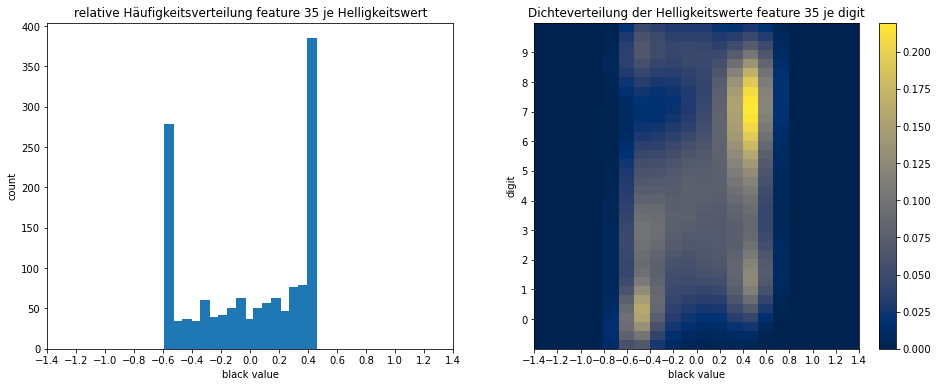

rows = 1437
all numeric = True (float64)
mean = -0.0012473460674595495
std = 0.38350711636691565
corrcoef = 0.6385193027431453 
 

feature 36 (36):


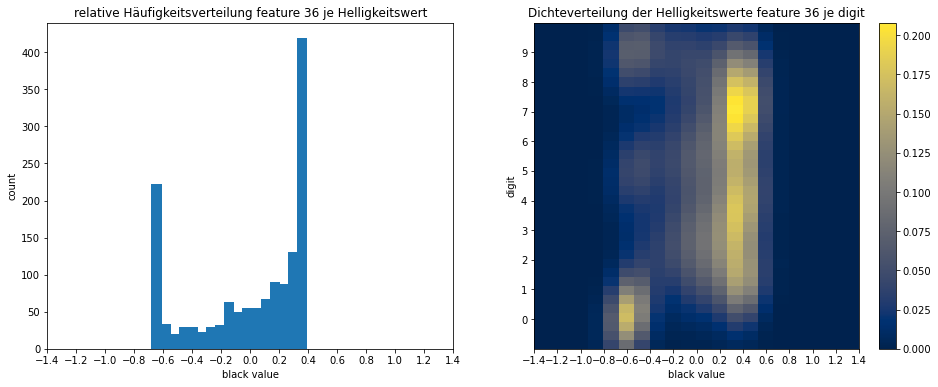

rows = 1437
all numeric = True (float64)
mean = -0.0014160460005340136
std = 0.3743374850765762
corrcoef = 0.584039143801233 
 

feature 37 (37):


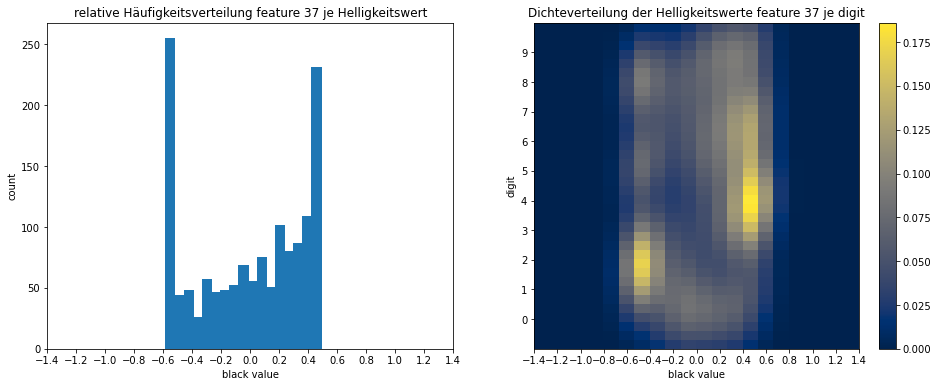

rows = 1437
all numeric = True (float64)
mean = -0.002287059657563717
std = 0.36953955901001034
corrcoef = 0.5760451823555636 
 

feature 38 (38):


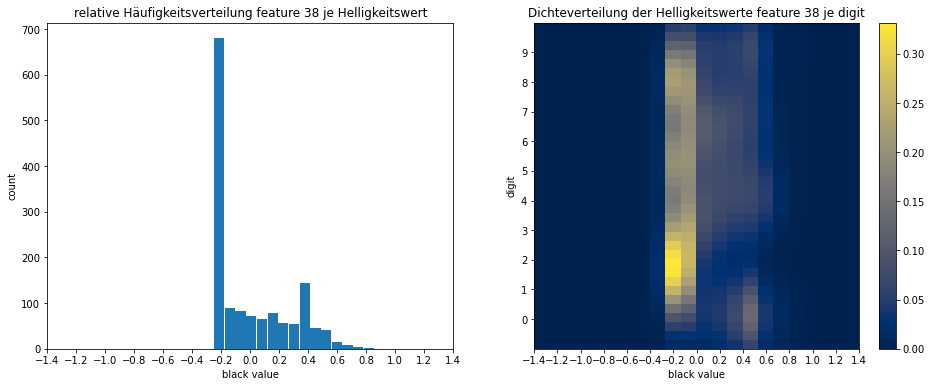

rows = 1437
all numeric = True (float64)
mean = -0.0020900232922554446
std = 0.2591465249984927
corrcoef = 0.49621383938171826 
 

feature 39 (39):


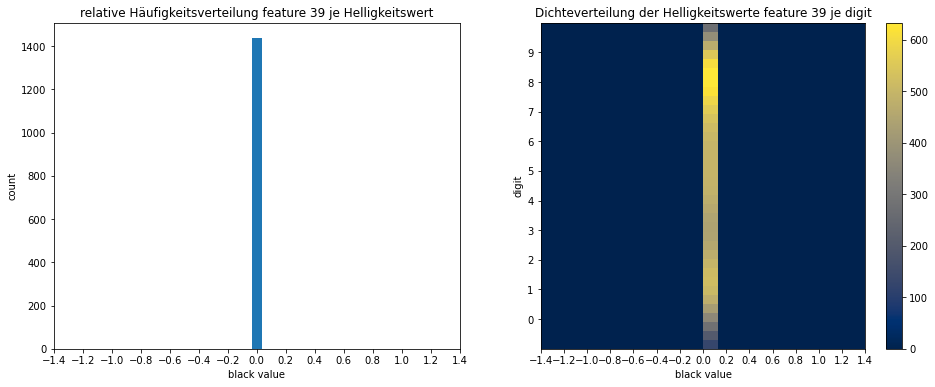

rows = 1437
all numeric = True (float64)
mean = 0.0
std = 0.0
corrcoef = nan 
 

feature 40 (40):


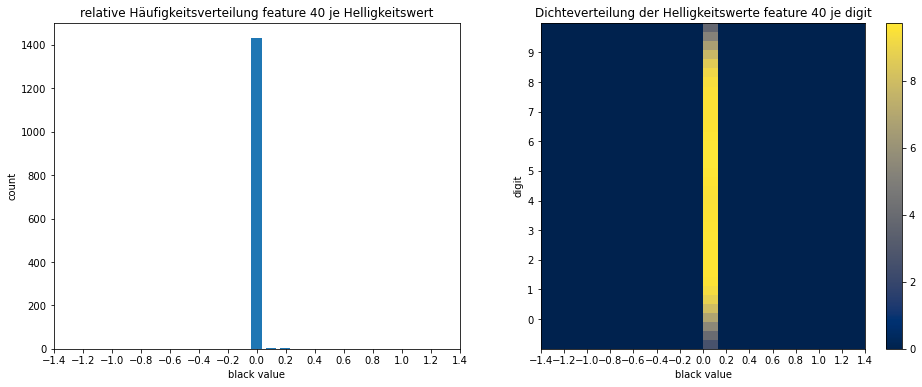

rows = 1437
all numeric = True (float64)
mean = -0.00012310242664735226
std = 0.013490156149308985
corrcoef = 0.49541636574208503 
 

feature 41 (41):


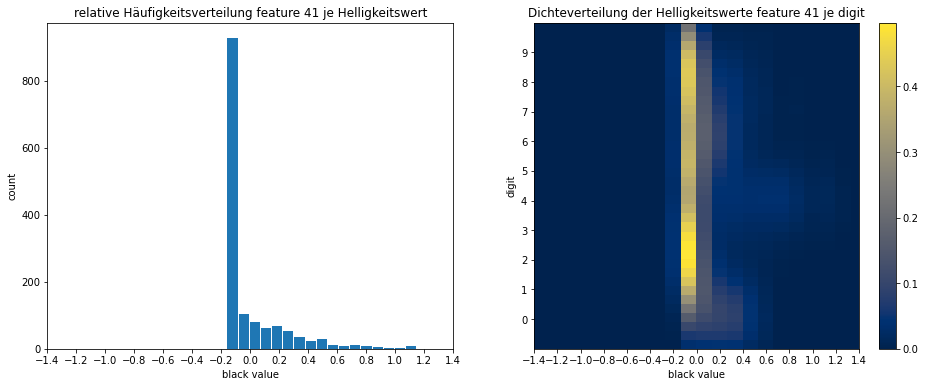

rows = 1437
all numeric = True (float64)
mean = -0.002725990599661394
std = 0.22106890434246654
corrcoef = 0.43069015179990955 
 

feature 42 (42):


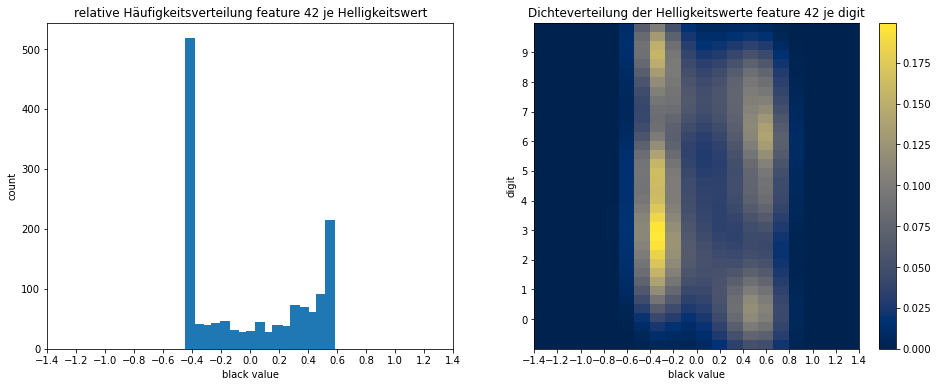

rows = 1437
all numeric = True (float64)
mean = -0.0023428212915480792
std = 0.3933283964406198
corrcoef = 0.4410333617764365 
 

feature 43 (43):


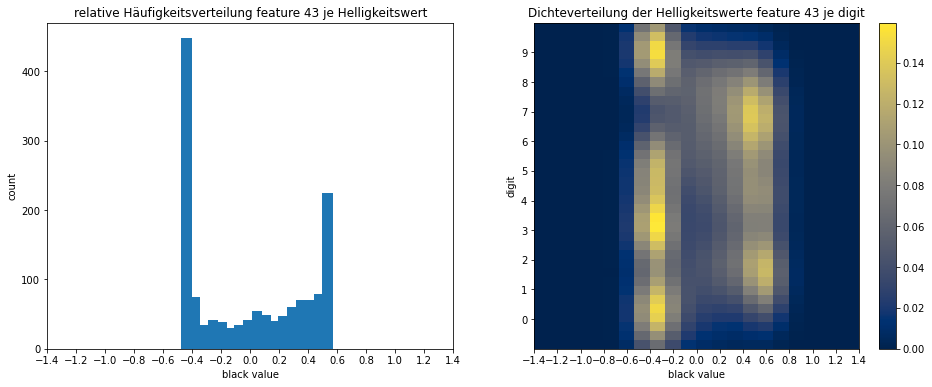

rows = 1437
all numeric = True (float64)
mean = -0.0052008444869500485
std = 0.3888549877745752
corrcoef = 0.5050550317452737 
 

feature 44 (44):


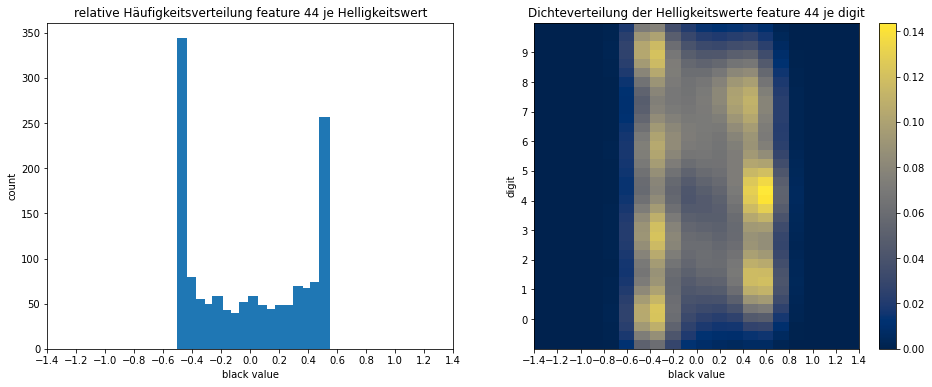

rows = 1437
all numeric = True (float64)
mean = -0.005179116198405435
std = 0.38437439342148705
corrcoef = 0.4889325023137051 
 

feature 45 (45):


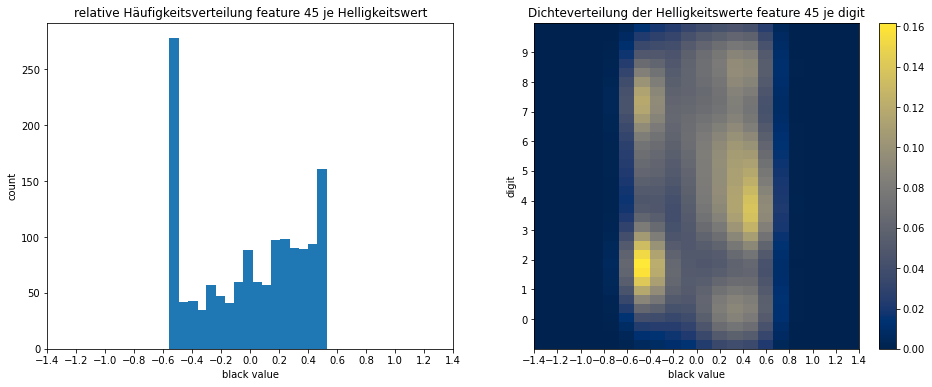

rows = 1437
all numeric = True (float64)
mean = -0.0006588315422564965
std = 0.36383235313343015
corrcoef = 0.5049916496961423 
 

feature 46 (46):


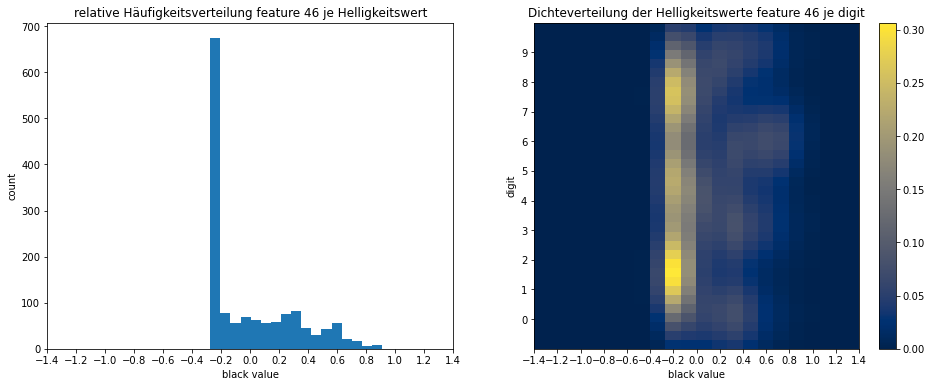

rows = 1437
all numeric = True (float64)
mean = 0.003461262922029246
std = 0.30169178708380523
corrcoef = 0.5328646284846207 
 

feature 47 (47):


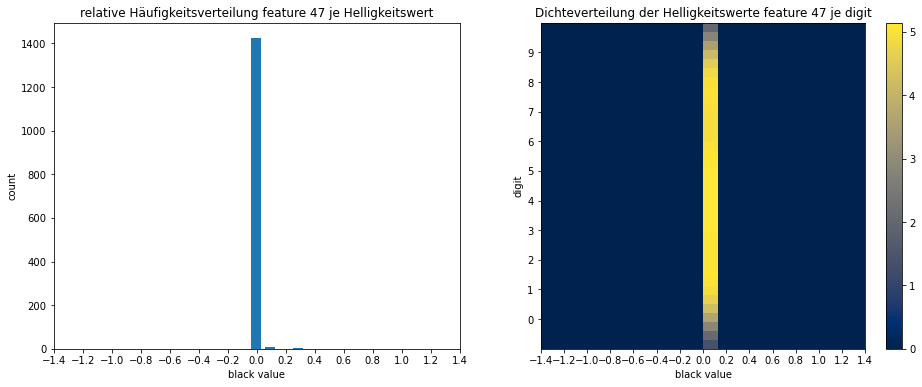

rows = 1437
all numeric = True (float64)
mean = -0.0008225770735451204
std = 0.024346397306709747
corrcoef = 0.5160860487868583 
 

feature 48 (48):


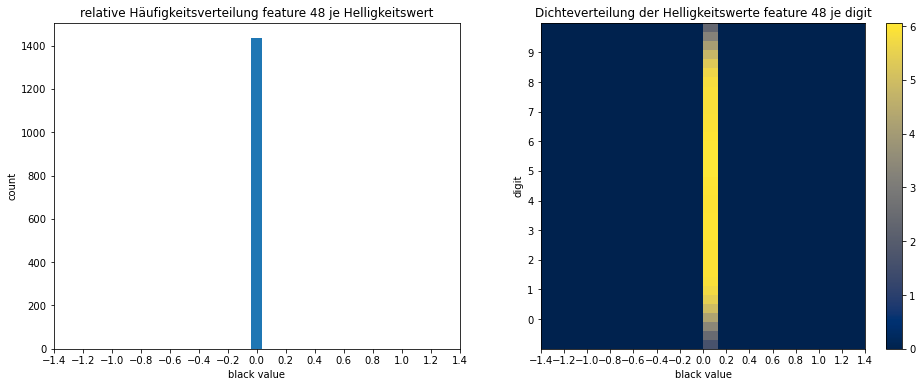

rows = 1437
all numeric = True (float64)
mean = 0.00010941132257448637
std = 0.02222366553837121
corrcoef = 0.493774813672524 
 

feature 49 (49):


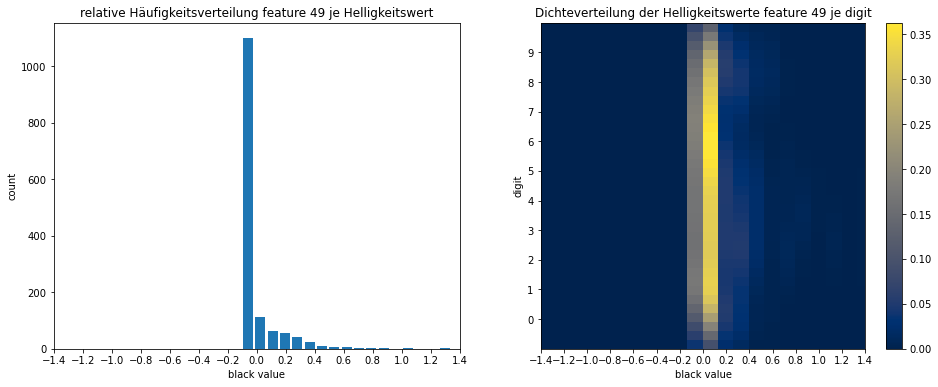

rows = 1437
all numeric = True (float64)
mean = -2.235358411104478e-05
std = 0.14736550971023976
corrcoef = 0.47919406470659587 
 

feature 50 (50):


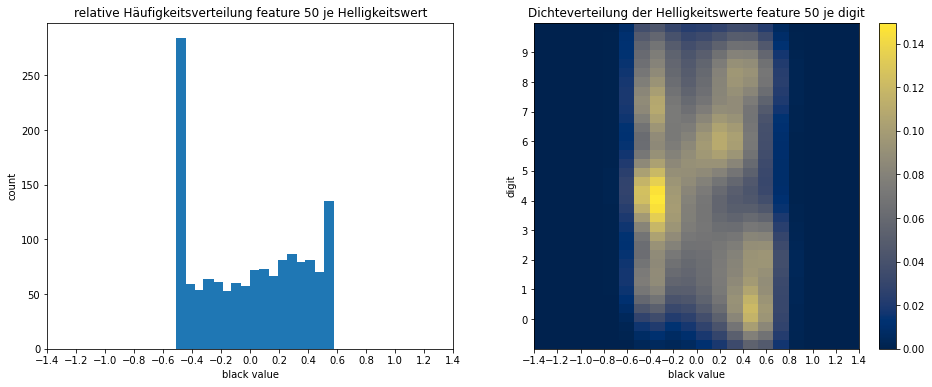

rows = 1437
all numeric = True (float64)
mean = 0.0021577661212331856
std = 0.35964002472235557
corrcoef = 0.4329945820058779 
 

feature 51 (51):


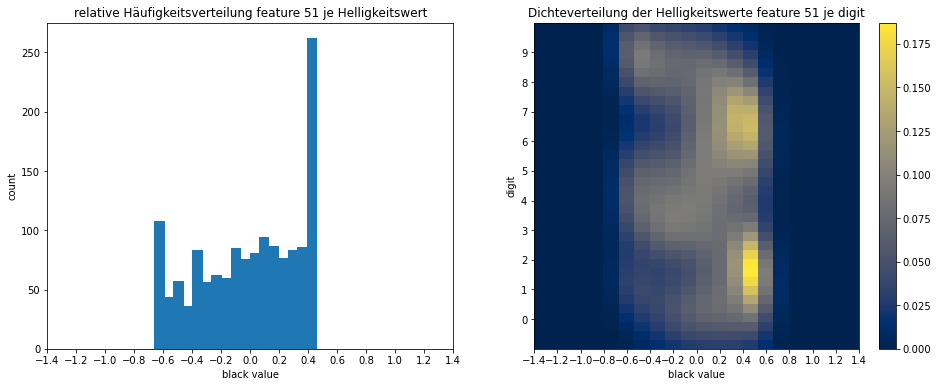

rows = 1437
all numeric = True (float64)
mean = -0.006438879478640201
std = 0.345255648033571
corrcoef = 0.41095321509348737 
 

feature 52 (52):


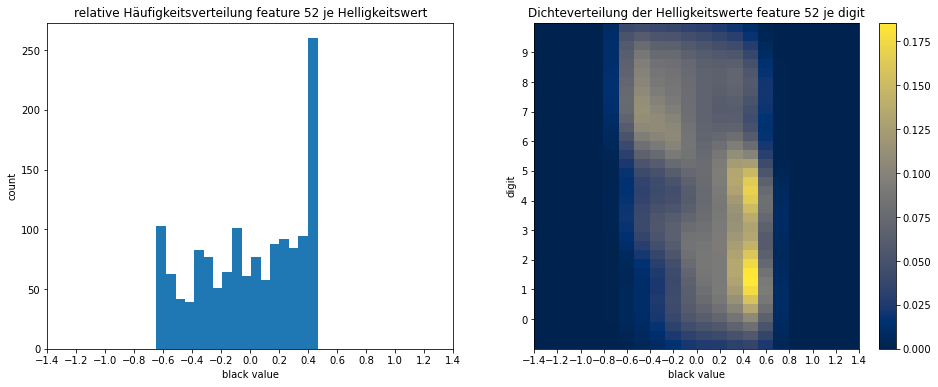

rows = 1437
all numeric = True (float64)
mean = -0.0015077257412195913
std = 0.34711886916020285
corrcoef = 0.30564729238517263 
 

feature 53 (53):


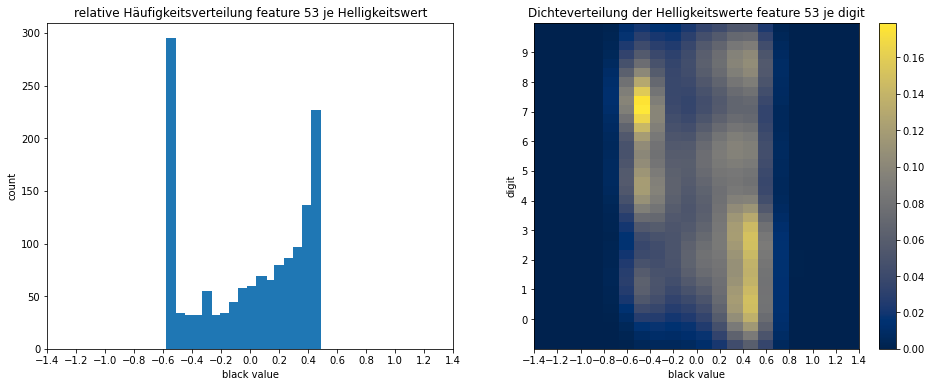

rows = 1437
all numeric = True (float64)
mean = 0.0013916208592622678
std = 0.3754733638812952
corrcoef = 0.4037648858918468 
 

feature 54 (54):


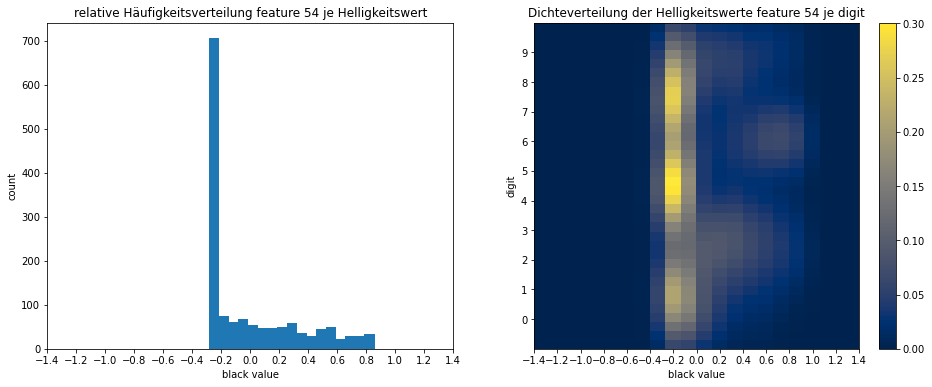

rows = 1437
all numeric = True (float64)
mean = -0.0014444476775168419
std = 0.32724703089514057
corrcoef = 0.5187582640127655 
 

feature 55 (55):


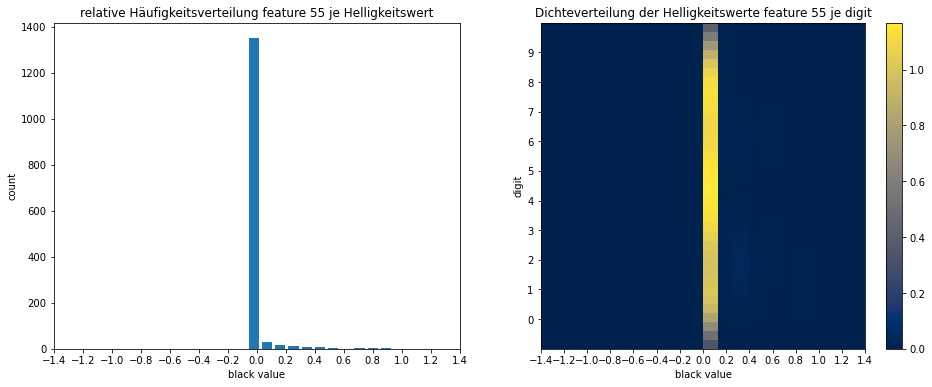

rows = 1437
all numeric = True (float64)
mean = -0.0016266990017767813
std = 0.08758190630757137
corrcoef = 0.4472645596043382 
 

feature 56 (56):


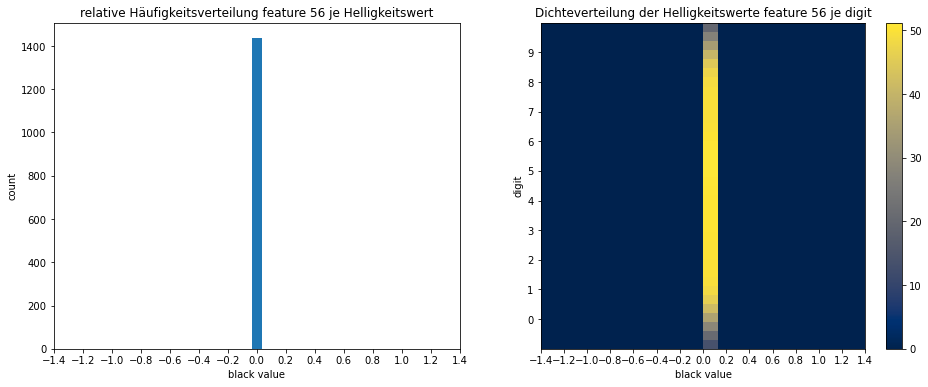

rows = 1437
all numeric = True (float64)
mean = 1.3908319235747161e-05
std = 0.002630858235987091
corrcoef = 0.4886432592156015 
 

feature 57 (57):


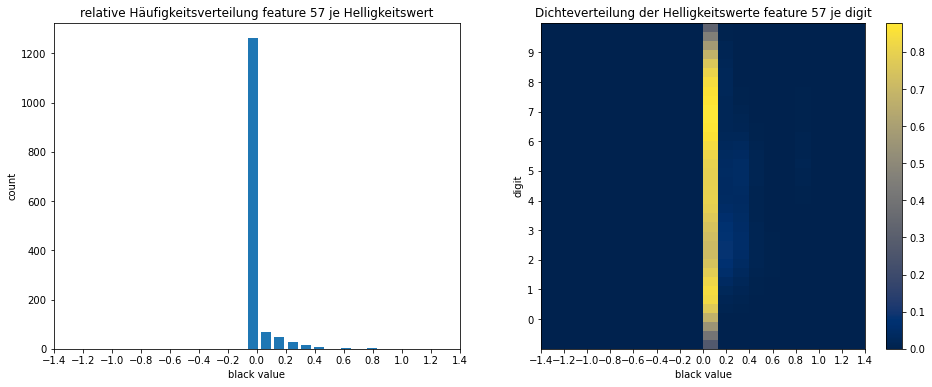

rows = 1437
all numeric = True (float64)
mean = -9.116391498883869e-05
std = 0.08498000218621267
corrcoef = 0.47584120516940454 
 

feature 58 (58):


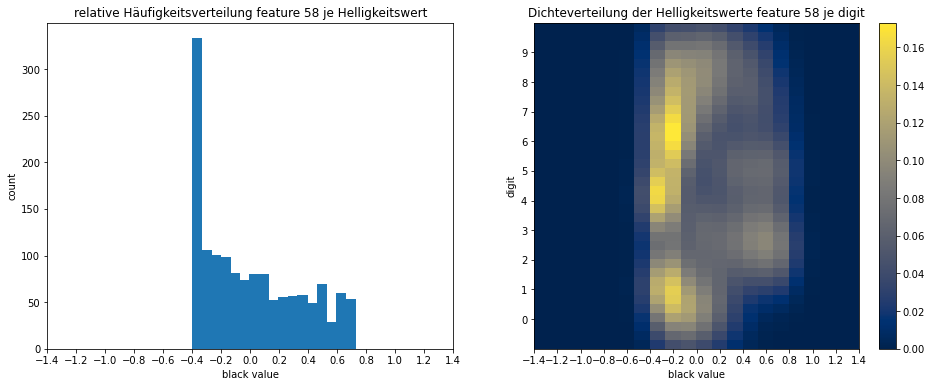

rows = 1437
all numeric = True (float64)
mean = 0.005978276042023694
std = 0.3392606686730076
corrcoef = 0.5048751355215817 
 

feature 59 (59):


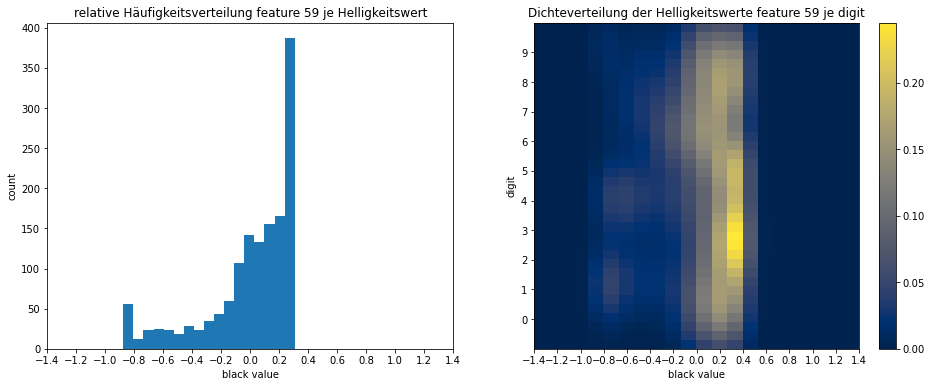

rows = 1437
all numeric = True (float64)
mean = 0.00038990776277002904
std = 0.3044799431513298
corrcoef = 0.49376808391832977 
 

feature 60 (60):


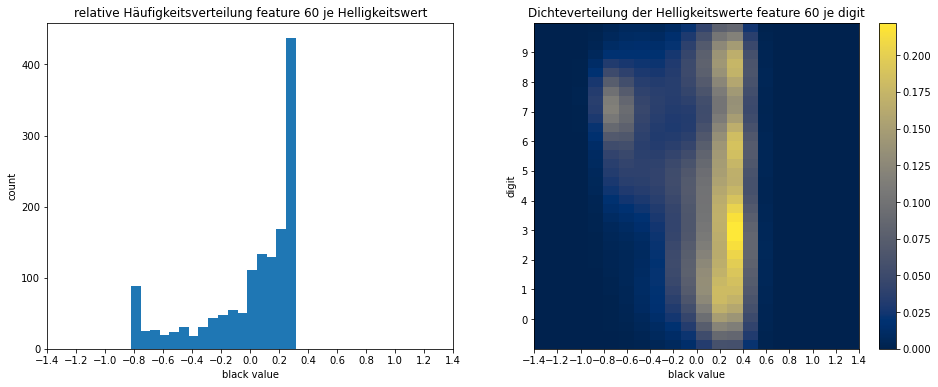

rows = 1437
all numeric = True (float64)
mean = -0.00035951556090260754
std = 0.33048383979776824
corrcoef = 0.40703748841960463 
 

feature 61 (61):


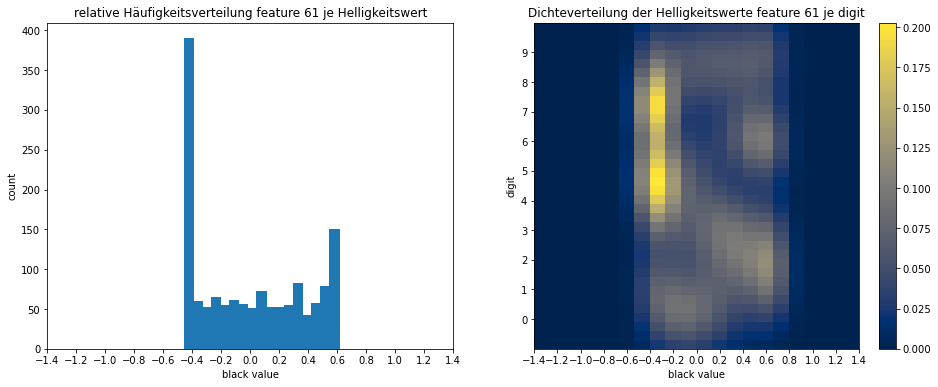

rows = 1437
all numeric = True (float64)
mean = -4.121224108490845e-05
std = 0.3697536668373441
corrcoef = 0.46182840657730423 
 

feature 62 (62):


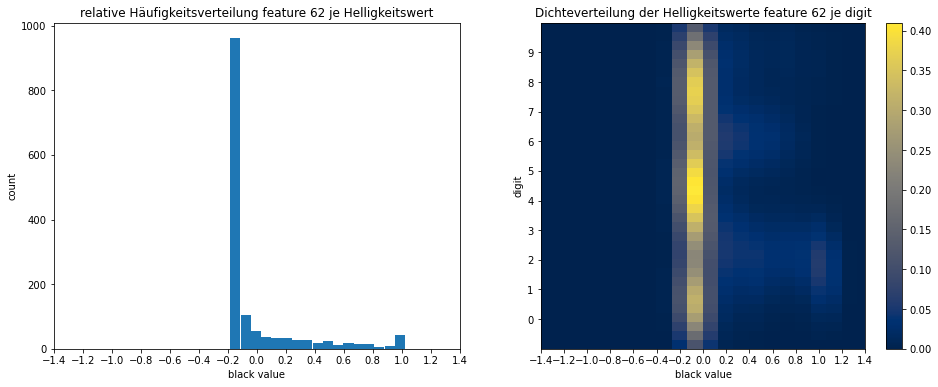

rows = 1437
all numeric = True (float64)
mean = -0.0006203184198282623
std = 0.2905767834739067
corrcoef = 0.44083820629569787 
 

feature 63 (63):


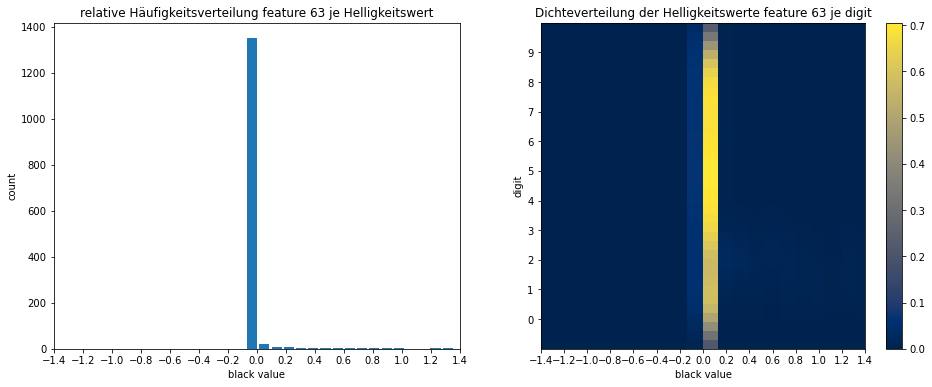

rows = 1437
all numeric = True (float64)
mean = -0.001454109675024143
std = 0.15180573889920182
corrcoef = 0.40972045616823066 
 



In [40]:
mean_train, std_train = [], []
coeffs = []



labels = np.arange(-1.4,1.5,0.2)
xmax = 1.4
xmin = -1.4

for ind, col in enumerate(X_train.T):

    # print(df[col].describe())
    mean, std = lr.StandardScaler_fit(col)
    mean_train.append(mean)
    std_train.append(std)
    print(f'feature {ind} ({ind}):')
    fig1 = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs[0])
    ax.set_xlabel('black value')
    ax.set_ylabel("count")
    ax.set_title(f"relative Häufigkeitsverteilung feature {ind} je Helligkeitswert")
    
    label, counts = np.unique(col, return_counts=True)

    ax.bar(label, counts, align='center', width=0.07)
    ax.set_xticks(labels)
    ax.set_xlim(xmin,xmax)
    ##
    ##
    
    # Verteilungsdichte bestimmen
    # random offset um die covarianz numerisch betimmen zu können
    rand = 0.0001*np.random.rand(np.size(col,0))-0.0001
    # KDE
    k = gaussian_kde(np.vstack([col+rand, y_train]))
    xi, yi = np.mgrid[xmin-1:xmax+1:col.size**0.5*1j, y_train.min()-1:y_train.max()+1:y_train.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    ax2 = plt.subplot(gs[1])
    ax2.set_xlabel('black value')
    ax2.set_ylabel("digit")
    ax2.set_xticks(labels)
    ax2.set_yticks(targets)
    ax2.set_ylim(-1,10)
    ax2.set_xlim(xmin,xmax)
    #ax2.matshow([col,y_train])
    
    #plot density
    #ax2.scatter(col, y_train, alpha=0.1)#, c=col, cmap=cm.cividis)
    #im = ax2.pcolormesh(xedges, yedges, Z.T)
    im = ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = cm.cividis, alpha=1)
    plt.colorbar(im)
    
    ##
    coeff = np.mean(np.corrcoef(col, y_train.T))
    coeffs.append(coeff)
    ax2.set_title(f"Dichteverteilung der Helligkeitswerte feature {ind} je digit")
    plt.show()

    #Feature beschreiben
    print(f'rows = {np.size(col)}\nall numeric = {not np.isnan(col).any()} ({col.dtype})\nmean = {mean}\nstd = {std}\ncorrcoef = {coeff}', '\n', '\n')


In [6]:
#X_train_9 =X_train[y_train==9]
y_train_t = []
y_test_t = []


for tar in targets:
    y_train_t.append(np.array([1 if y == tar else 0 for y in y_train]))
    y_test_t.append(np.array([1 if y == tar else 0 for y in y_test]))
    print(f'digit {tar}: {len(y_train_t[tar][y_train_t[tar]==1])} train pos label || {len(y_test_t[tar][y_test_t[tar]==1])} test pos label')
    #[147 147 138 150 137 153 141 139 146 139]

digit 0: 147 train pos label || 31 test pos label
digit 1: 147 train pos label || 35 test pos label
digit 2: 138 train pos label || 39 test pos label
digit 3: 150 train pos label || 33 test pos label
digit 4: 137 train pos label || 44 test pos label
digit 5: 153 train pos label || 29 test pos label
digit 6: 141 train pos label || 40 test pos label
digit 7: 139 train pos label || 40 test pos label
digit 8: 146 train pos label || 28 test pos label
digit 9: 139 train pos label || 41 test pos label


In [7]:
#X_train is np.dtype(np.float64).type
X_train is np.dtype('float64') 
#type(X_train)

False

In [12]:
X_train = np.float64(X_train)


thetas = []
Js = []
counters = []
for tar in targets:
    time_start = time.time()
    print(f'learning digit {tar}...')
    theta, J, counter = lr.LogisticRegression_fit(X_train, y_train_t[tar], 0.5, 3e-4)
    print('Calculating Thetas done... \n',theta,'\n cost =',J,'\n')
    thetas.append(theta)
    Js.append(J)
    counters.append(counter)
    print(f'took {counter} iterations in {time.time()-time_start} seconds ({counter/(time.time()-time_start)} iter/sec)...\n\n')


learning digit 0...
Calculating Thetas done... 
 [-1.16275168e+01  0.00000000e+00 -3.23701971e-01 -5.80570005e-02
  1.03297660e+00 -4.05346493e-01 -3.21989654e+00 -1.89354191e+00
 -2.33955723e-01  5.34391702e-04 -8.85587111e-01  4.38583326e-01
  1.69710143e+00  2.31876042e+00  3.02334420e+00 -1.40755821e-02
 -3.20718761e-01 -1.82940911e-02  8.25706435e-01  1.50194384e+00
  2.50933363e-02 -3.35387278e+00  3.50679684e+00  3.00782223e-01
 -1.53045172e-01 -8.83115742e-03  9.21058416e-01  2.73143397e-01
 -2.05418049e+00 -6.34769826e+00  1.08757458e-01  5.68129213e-01
 -1.96201457e-02  0.00000000e+00  1.31350418e+00  1.90193923e+00
 -1.44452513e+00 -5.07803663e+00 -4.79457531e-01  3.10063265e-01
  0.00000000e+00 -5.58586760e-02 -1.40934289e-01  3.36409403e+00
 -4.44554140e+00 -3.13735239e+00 -2.36586217e-02  6.46395140e-01
  1.52167702e-02 -1.58180854e-01 -1.14613688e+00  1.08515035e+00
 -3.44225998e-01  9.36833586e-01 -6.97623904e-01 -2.16787309e+00
 -7.23875912e-01 -2.22252888e-04 -4.48753

Calculating Thetas done... 
 [-1.22405453e+01  0.00000000e+00 -1.82462352e+00  5.80592491e-01
  2.58925123e+00  1.97982448e+00  2.50946976e+00  1.52856242e+00
  1.89571836e+00  6.80600069e-04 -2.32282832e+00 -3.03912342e-01
 -2.18154624e-01  7.72055231e+00  1.19879115e+00 -9.29011398e-01
  3.55082799e+00  1.14536055e-03 -1.84779748e+00 -4.00616329e+00
 -4.33329261e+00 -2.84704582e+00 -5.36301354e-01  1.72304655e+00
  2.11431135e-01  9.93711294e-04 -5.84072613e+00 -3.96234849e-01
 -2.82650057e+00 -6.34546574e-03  1.74400370e+00  2.00822653e+00
 -2.17312379e-01  0.00000000e+00  2.39047830e+00 -4.89527354e-01
  1.01210157e+00  8.90613687e-01  1.89798737e+00  3.85722678e+00
  0.00000000e+00 -6.65430430e-03 -3.22063446e+00  8.58021761e-01
  1.84671571e+00  2.11641482e+00  2.37920161e+00 -3.12616787e-01
  1.81582632e-02  2.21871153e-03 -2.38760525e-01  4.79897968e-01
  3.39364946e-01 -7.89311004e+00 -7.45363524e+00 -6.63033520e-01
  8.66609913e-02 -4.56058774e-04 -2.74150049e+00 -3.36948417e

digit = 0
Accuracy:  1.0 
Precision:  1.0 
Recall:  1.0 


digit = 1
Accuracy:  0.9861111111111112 
Precision:  0.9428571428571428 
Recall:  0.9166666666666666 


digit = 2
Accuracy:  1.0 
Precision:  1.0 
Recall:  1.0 


digit = 3
Accuracy:  0.9861111111111112 
Precision:  0.8484848484848485 
Recall:  1.0 


digit = 4
Accuracy:  0.9972222222222222 
Precision:  0.9772727272727273 
Recall:  1.0 


digit = 5
Accuracy:  1.0 
Precision:  1.0 
Recall:  1.0 


digit = 6
Accuracy:  1.0 
Precision:  1.0 
Recall:  1.0 


digit = 7
Accuracy:  0.9916666666666667 
Precision:  0.925 
Recall:  1.0 


digit = 8
Accuracy:  0.9666666666666667 
Precision:  0.75 
Recall:  0.8076923076923077 


digit = 9
Accuracy:  0.9833333333333333 
Precision:  0.975609756097561 
Recall:  0.8888888888888888 




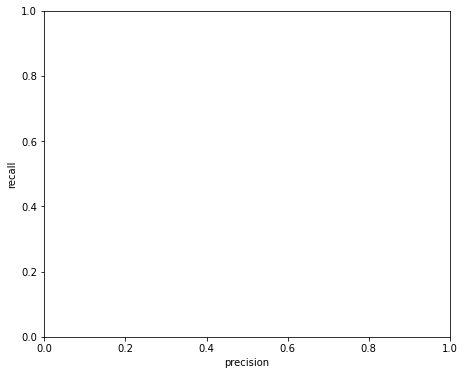

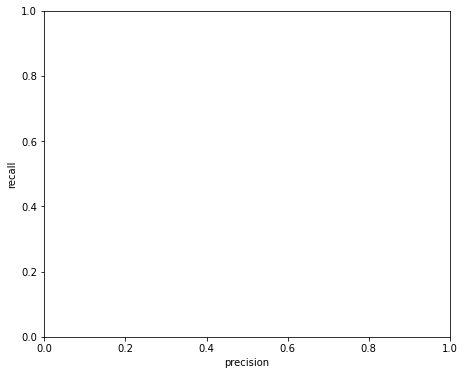

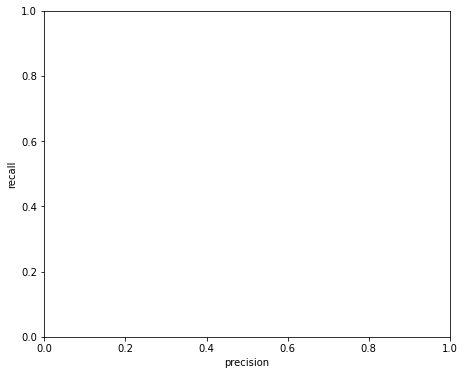

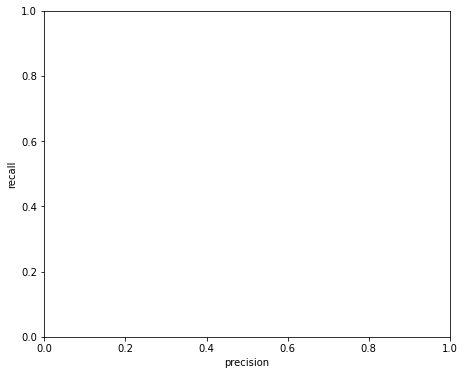

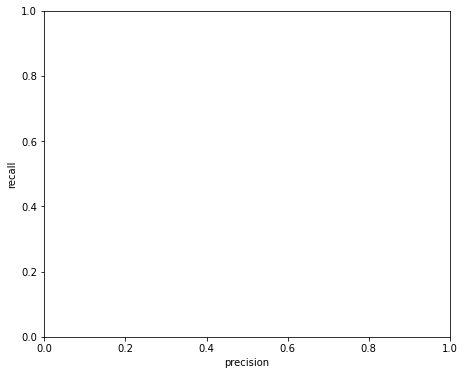

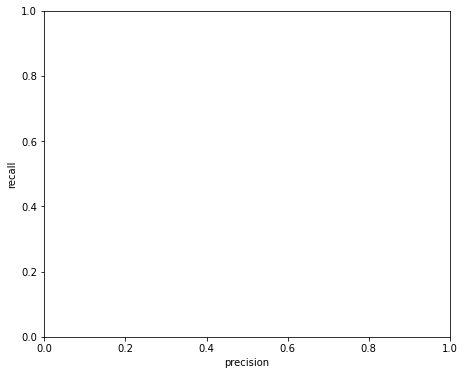

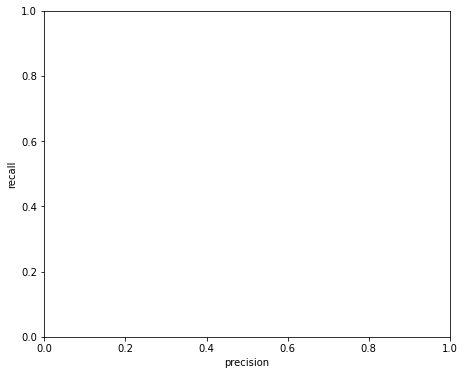

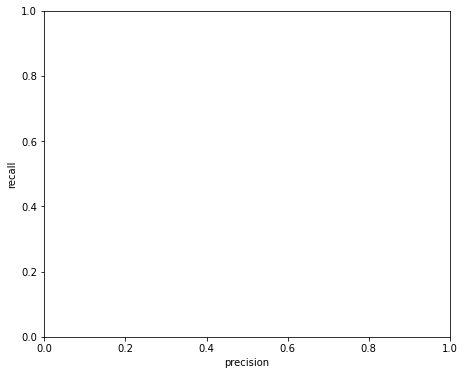

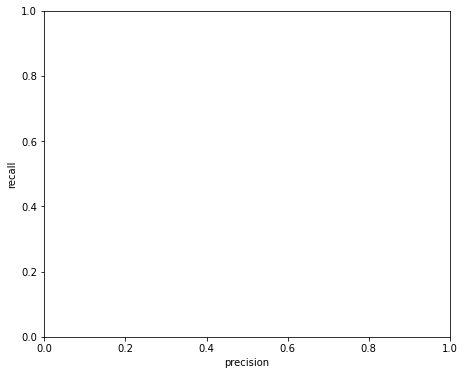

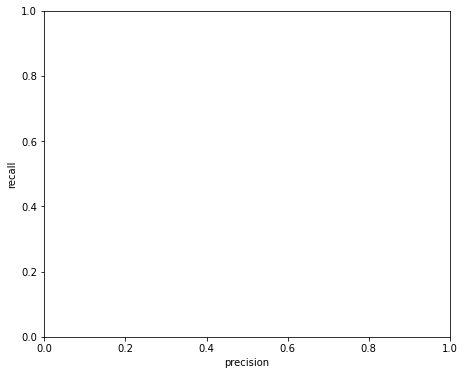

In [14]:
from sklearn.metrics import precision_recall_curve

for tar in targets:
    print(f'digit = {tar}')
    #tar = 0
    y_pred = lr.LogisticRegression_predict(X_test, thetas[tar])
    #print(y_pred)
    #print(y_test_t[tar])
    acc = lr.accuracy_score(y_pred,y_test_t[tar])
    precision = lr.precision_score(y_pred,y_test_t[tar])
    recall = lr.recall_score(y_pred,y_test_t[tar])
    fig1 = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs[0])
    ax.set_xlabel('precision')
    ax.set_ylabel("recall")
    #ax.set_title(f"relative Häufigkeitsverteilung feature {ind} je Helligkeitswert")
    print('Accuracy: ',acc,'\nPrecision: ',precision,'\nRecall: ', recall,'\n\n')


In [ ]:
print(len(thetas))